In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from datasets.generators1d import * 
from datasets.generators import Cavity2D
from datasets.settings import OMEGA, MU0, EPSILON0, SCALE, C, L0, PIXEL_SIZE
from models.utils import pbar, tensor_diff, tensor_roll

In [3]:
device = torch.device('cuda:0')

In [3]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=64, src_x=None, use_A_phi=False):
        super().__init__()
        
        self.size = size
        if src_x is None:
            self.src_x = size // 2
        else:
            self.src_x = src_x
        self.use_A_phi = use_A_phi
        self.cavity_buffer = 16

#         self.layer_dims = [self.size, 128, 256, 512, 512, 256, self.size]
        self.layer_dims = [self.size]+[1024]*6+[self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        if self.use_A_phi:
            self.layers_phi = nn.ModuleList(layers_phi)
            
        # store angler operators
        curl_op, eps_op = Cavity1D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor([np.asarray(np.real(curl_op))], device=device).float()
        self.epsilon_op = torch.tensor([np.asarray(np.real(eps_op))], device=device).float()
        
    def forward_amplitude_phase(self, x):
        A = x
        imax = len(self.layers_amp) - 1
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < imax:
                A = nn.ReLU()(A)
            else:
                A = nn.ELU()(A) + 1
                
        phi = x
        imax = len(self.layers_phi) - 1
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < imax:
                phi = nn.ReLU()(phi)
            else:
                phi = 2 * np.pi * nn.Tanh()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, add_zero_bc=False):
        # Get amplitude and phase vectors
        if not self.use_A_phi:
            A = epsilons
            imax = len(self.layers_amp) - 1
            for i, layer in enumerate(self.layers_amp):
                A = layer(A)
                if i < imax:
                    A = nn.ReLU()(A)
            return A
            
        A, phi = self.forward_amplitude_phase(epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        if add_zero_bc:
            batch_size, _ = epsilons.shape
            zero = torch.zeros((batch_size, 1), device=device)  
            fields = torch.cat([zero, fields, zero], dim=-1)
            
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        batch_size, _ = epsilons.shape

        # Add zero field amplitudes at edge points for resonator BC's
        zero = torch.zeros((batch_size, self.cavity_buffer), device=device)
        E = torch.cat([zero, fields, zero], dim=-1)
        E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
        barrier = torch.full((batch_size, self.cavity_buffer), -1e20, device=device)
        eps = torch.cat([barrier, epsilons, barrier], dim=-1)
        eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
#         diffs = tensor_diff(E, n=2, padding=None)
#         curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
#         epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        curl_curl_E = (SCALE / L0**2) * torch.bmm(self.curl_curl_op, E).view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

#         epsilon_E = torch.bmm(self.epsilon_op, eps*E)

        # Compute free-current vector
        J = torch.zeros_like(curl_curl_E)
        J[:,self.src_x + self.cavity_buffer, 0] = -1.526814027933079 
#         J[:, self.src_x + 1, 0] = 1.526814027933079e3
    
#         breakpoint()

        out = curl_curl_E - epsilon_E - J

        return out[:, self.cavity_buffer:-self.cavity_buffer]

In [4]:
def neural_field_solve(epsilons, src_x=32, target_loss=1e-5, max_epochs=1e4):
    model = MaxwellDense(size=len(epsilons)).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    epsilons = torch.tensor([epsilons]).float().to(device)
    
    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    
    p.close()
    
    model.eval()        
    return model.get_fields(epsilons)[0].cpu().detach().numpy(), model(epsilons)[0].cpu().detach().numpy()

In [9]:
def neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4):
    start = time()
    _, src_x, Hx, Hy, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=16).solve(epsilons, omega=OMEGA_1550)
    sim_time = time() - start

    Ez = np.real(Ez)[16:-16]
    
    start = time()
    Ez_pred, outputs = neural_field_solve(epsilons, target_loss=target_loss, max_epochs=max_epochs)
    network_time = time() - start

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))
    
#     outputs = outputs[1:-1]
    scale_ratio = np.mean(np.abs(Ez)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio
    
    _ = plt.figure(figsize=(12,6))
    plt.plot(epsilons, label="Permittivity")
    plt.plot(Ez_pred, label="$E_\mathrm{pred}$")
    plt.plot(Ez, label="$E_\mathrm{true}$")
    plt.plot(-10 + 20*outputs, label="Model output")
    plt.plot(-10 * np.ones(outputs.shape), linestyle=':')
    plt.vlines(src_x, -10, 10)
    plt.legend()

    plt.show()


Sim time: 0.01216 | Network time: 68.58968 | Ratio: 5642.45016


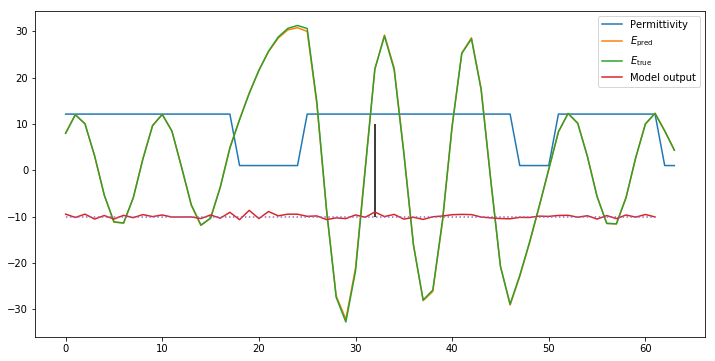

In [6]:
epsilons = perm_random_number_alternating_layers()
# epsilons = perm_random()
neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4)

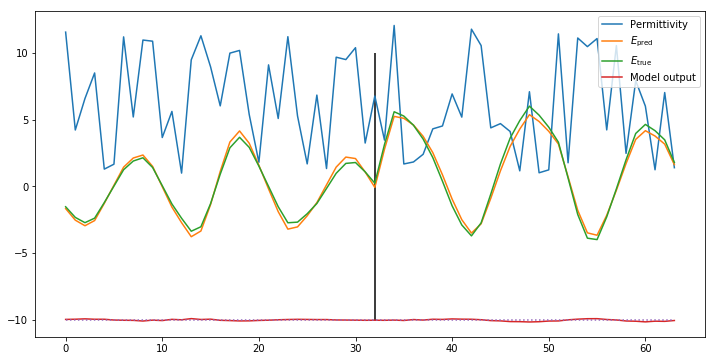

In [67]:
neural_solve_plot(epsilons, target_loss=1e-5, max_epochs=1e4)

## 2D case

In [46]:
class MaxwellDense2D(nn.Module):
    
    def __init__(self, size=32, src_x=None):
        super().__init__()
        
        self.size = size
        if src_x is None:
            self.src_x = size // 2
        else:
            self.src_x = src_x

        self.cavity_buffer = 4
        self.total_size = self.size + 2 * self.cavity_buffer

        self.layer_dims = [self.size**2]+[4*1024]*6+[self.size**2]

        layers = []
        for i in range(len(self.layer_dims) - 1):
            layers.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers = nn.ModuleList(layers)
            
        # store angler operators
        curl_op, eps_op = Cavity2D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor([np.asarray(np.real(curl_op))], device=device).float()
#         self.epsilon_op = torch.tensor([np.asarray(np.real(eps_op))], device=device).float()
    
    def get_fields(self, epsilons, add_zero_bc=False):
        
        batch_size, _, _ = epsilons.shape

        E = epsilons.view(batch_size, -1)
        imax = len(self.layers) - 1
        for i, layer in enumerate(self.layers):
            E = layer(E)
            if i < imax:
                E = nn.ReLU()(E)

        E = E.view(batch_size, self.size, self.size)
        return E
    
    def forward(self, epsilons):    
        batch_size, _, _ = epsilons.shape

        # Compute Ez fields
        fields = self.get_fields(epsilons)
    
        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(fields, [self.cavity_buffer]*4)
        E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
#         barrier = torch.full((batch_size, self.cavity_buffer), -1e20, device=device)
        eps = F.pad(epsilons, [self.cavity_buffer]*4, "constant", -1e20)
        eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
#         diffs = tensor_diff(E, n=2, padding=None)
#         curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
#         epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        curl_curl_E = (SCALE / L0**2) * torch.bmm(self.curl_curl_op, E).view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

#         epsilon_E = torch.bmm(self.epsilon_op, eps*E)

        # Compute free-current vector
        J = torch.zeros(batch_size, self.total_size, self.total_size, device=device)
        J[:, self.src_x + self.cavity_buffer, self.src_x + self.cavity_buffer] = -1.526814027933079 
        J = J.view(batch_size, -1, 1)
#         J[:, self.src_x + 1, 0] = 1.526814027933079e3
    
#         breakpoint()

        out = curl_curl_E - epsilon_E - J
        out = out.view(batch_size, self.total_size, self.total_size)
        out = out[:, self.cavity_buffer:-self.cavity_buffer, self.cavity_buffer:-self.cavity_buffer]

        return out

In [53]:
def neural_field_2dsolve(epsilons, src_x=32, target_loss=1e-5, max_epochs=1e4, lr=1e-5):
    model = MaxwellDense2D(size=len(epsilons)).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epsilons = torch.tensor([epsilons]).float().to(device)
    
    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    
    p.close()
    
    model.eval()        
    return model.get_fields(epsilons)[0].cpu().detach().numpy(), model(epsilons)[0].cpu().detach().numpy()

In [54]:
def neural_solve_2dplot(epsilons, target_loss=1e-5, max_epochs=1e4, lr=1e-5):
    start = time()
    _, src_x, src_y, Hx, Hy, Ez = Cavity2D(device_length=len(epsilons), cavity_buffer=4).solve(epsilons, omega=OMEGA_1550)
    sim_time = time() - start

    Ez = np.real(Ez)[4:-4, 4:-4]
    
    start = time()
    Ez_pred, outputs = neural_field_2dsolve(epsilons, target_loss=target_loss, max_epochs=max_epochs, lr=lr)
    network_time = time() - start

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))
    
#     outputs = outputs[1:-1]
    scale_ratio = np.mean(np.abs(Ez)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio
    
    f, ax = plt.subplots(2, 2, figsize=(12,12))
    ax[0,0].imshow(Ez_pred)
    ax[0,1].imshow(Ez)
    ax[1,0].imshow(epsilons)
    ax[1,1].imshow(outputs)

    plt.show()


Sim time: 0.02184 | Network time: 411.57256 | Ratio: 18845.84355


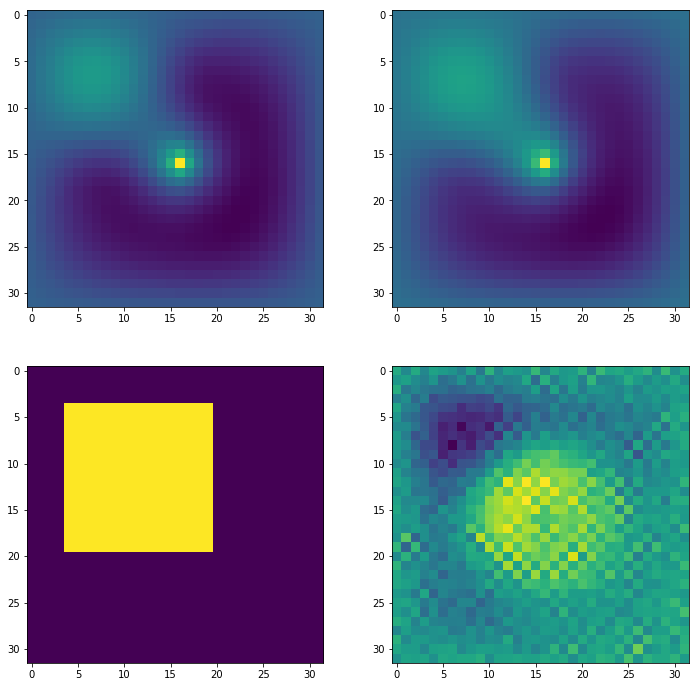

In [8]:
eps2 = np.ones((32, 32))
eps2[4:20, 4:20] = 2.5

neural_solve_2dplot(eps2, target_loss=1e-6, max_epochs=1e4)

## Direct 2D field solver

In [31]:
class MaxwellFlat2D(nn.Module):
    
    def __init__(self, size=32, src_x=None, E_init=None):
        super().__init__()
        
        self.size = size
        if src_x is None:
            self.src_x = size // 2
        else:
            self.src_x = src_x

        self.cavity_buffer = 4
        self.total_size = self.size + 2 * self.cavity_buffer
            
        if E_init is None:
            E_init = torch.zeros(self.size, self.size)
        self.fields = nn.Parameter(E_init, requires_grad=True)

        # store angler operators
        curl_op, eps_op = Cavity2D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor(np.asarray(np.real(curl_op)), device=device).float()  
    
    def forward(self, epsilons):    
    
        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(self.fields, [self.cavity_buffer]*4)
        E = E.view(-1, 1)

        # Add first layer of cavity BC's
#         barrier = torch.full((batch_size, self.cavity_buffer), -1e20, device=device)
        eps = F.pad(epsilons, [self.cavity_buffer]*4, "constant", -1e20)
        eps = eps.view(-1, 1)

        # Compute Maxwell operator on fields
#         diffs = tensor_diff(E, n=2, padding=None)
#         curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
#         epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

        curl_curl_E = (SCALE / L0**2) * torch.matmul(self.curl_curl_op, E).view(-1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E
        
        # Compute free-current vector
        J = torch.zeros(self.total_size, self.total_size, device=device)
        J[self.src_x + self.cavity_buffer, self.src_x + self.cavity_buffer] = -1.526814027933079 
        J = J.view(-1, 1)
        J[self.src_x + 1, 0] = 1.526814027933079e3
    
        out = curl_curl_E - epsilon_E - J
        out = out.view(self.total_size, self.total_size)
        out = out[self.cavity_buffer:-self.cavity_buffer, self.cavity_buffer:-self.cavity_buffer]

        return out

In [32]:
def neural_field_flat_2dsolve(epsilons, src_x=32, target_loss=1e-5, max_epochs=1e4, lr=1e-4, E_init=None):
    model = MaxwellFlat2D(size=len(epsilons), E_init=E_init).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epsilons = torch.tensor(epsilons).float().to(device)
    
    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    
    p.close()
    
    model.eval()        
    return model.fields.cpu().detach().numpy(), model(epsilons).cpu().detach().numpy()

In [33]:
def neural_solve_flat_2dplot(epsilons, target_loss=1e-5, max_epochs=1e4, lr=1e-4, E_init=None):
    start = time()
    _, src_x, src_y, Hx, Hy, Ez = Cavity2D(device_length=len(epsilons), cavity_buffer=4).solve(epsilons, omega=OMEGA_1550)
    sim_time = time() - start

    Ez = np.real(Ez)[4:-4, 4:-4]
    
    start = time()
    Ez_pred, outputs = neural_field_flat_2dsolve(epsilons, target_loss=target_loss, max_epochs=max_epochs, lr=lr, E_init=E_init)
    network_time = time() - start

    print("Sim time: {:.5f} | Network time: {:.5f} | Ratio: {:.5f}".format(
        sim_time, network_time, network_time / sim_time))
    
#     outputs = outputs[1:-1]
    scale_ratio = np.mean(np.abs(Ez)) / np.mean(np.abs(Ez_pred))
    Ez_pred *= scale_ratio
    
    f, ax = plt.subplots(2, 2, figsize=(12,12))
    ax[0,0].imshow(Ez_pred)
    ax[0,1].imshow(Ez)
    ax[1,0].imshow(epsilons)
    ax[1,1].imshow(outputs)

    plt.show()

Sim time: 0.03607 | Network time: 74.82012 | Ratio: 2074.15990


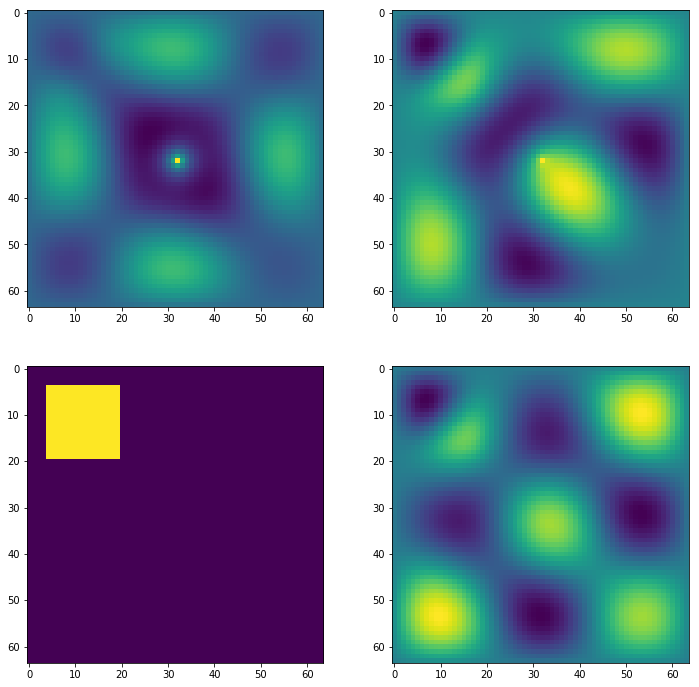

In [57]:
eps2 = np.ones((64, 64))
eps2[4:20, 4:20] = 2.5

_, _, _, _, _, Ez = Cavity2D(device_length=32, cavity_buffer=2).solve(eps2[::2, ::2], omega=OMEGA_1550)
E_init = F.interpolate(torch.tensor([[np.real(Ez)[2:-2,2:-2]]]), size=(64,64)).view(64,64).float()

neural_solve_flat_2dplot(eps2, target_loss=1e-7, max_epochs=3e4, lr=1e-4, E_init=None)

## Stanford permittivity demo

In [35]:
# Load image and convert to bit matrix 
im = np.asarray(Image.open("img/stanford_logo.png").convert("1")).astype(float)
im = (eps_sio2 - 1) * im + 1 # represent as glass

# Downsample  
im = im[::6,::6]

# Embed in square 
N = 128
stanford_epsilons = np.ones((N, N))
h, w = im.shape
y0, y1 = int(N//2 - np.floor(h/2)), int(N//2 + np.ceil(h/2))
x0, x1 = int(N//2 - np.floor(w/2)), int(N//2 + np.ceil(w/2))
stanford_epsilons[y0:y1, x0:x1] = im

# Downsample again
stanford_epsilons = stanford_epsilons[::2, ::2]

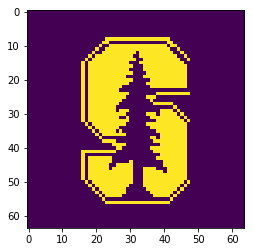

In [36]:
plt.imshow(stanford_epsilons)

Sim time: 0.03887 | Network time: 248.85999 | Ratio: 6402.46854


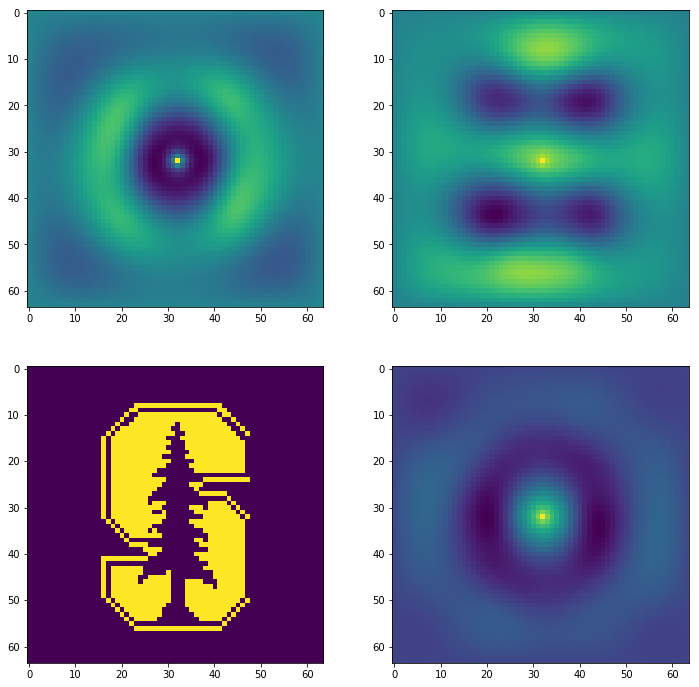

In [50]:
neural_solve_flat_2dplot(stanford_epsilons, target_loss=1e-7, max_epochs=1e5, lr=1e-5, E_init=None)

In [56]:
neural_solve_2dplot(stanford_epsilons, target_loss=1e-7, max_epochs=1e5, lr=1e-5)

RuntimeError: CUDA error: out of memory